In [1]:
import pickle
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import matplotlib
from hyperopt import fmin, hp, tpe
from sklearn.decomposition import PCA
import numpy as np

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 8)

In [2]:
with open('./data/output.pickle', 'rb') as f:
    data = pickle.load(f)
    data['vectors'] /= data['vectors'].std(0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1159 samples in 0.002s...
[t-SNE] Computed neighbors for 1159 samples in 0.137s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1159
[t-SNE] Computed conditional probabilities for sample 1159 / 1159
[t-SNE] Mean sigma: 2.027669
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.108910
[t-SNE] Error after 1000 iterations: 0.854573


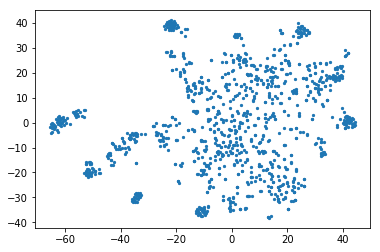

In [3]:
tsne = TSNE(n_components=2, verbose=True)
vectors_tsne = tsne.fit_transform(data['vectors'])
plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], s=5)
plt.show()

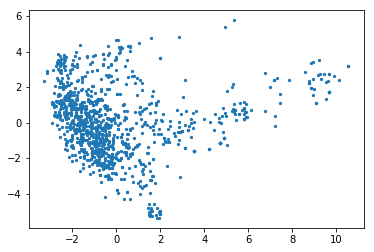

In [4]:
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(data['vectors'])
plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], s=5)
plt.show()

In [ ]:
def objective(hparams):
    klass, kwargs = hparams
    if 'n_clusters' in kwargs:
        kwargs['n_clusters'] = int(kwargs['n_clusters'])
        
    model = klass(**kwargs)
    cluster_ids = model.fit_predict(data['vectors'])
    
    if len(set(cluster_ids)) > 1:
        score = silhouette_score(data['vectors'], cluster_ids)
    else:
        score = -1
    
    return -score
    
hparams_space = hp.choice('method', [
#     (KMeans, {
#         'n_clusters': hp.quniform('kmeans_n_clusters', 2, 32, 1),
#     }),
    (DBSCAN, {
        'min_samples': hp.quniform('min_samples', 2, 32, 1),
        'eps': hp.loguniform('eps', np.log(0.01), np.log(32))
    }),
#     (AgglomerativeClustering, {
#         'affinity': hp.choice('affinity', ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']),
#         'n_clusters': hp.quniform('agglo_n_clusters', 2, 32, 1),
#         'linkage': hp.choice('linkage', ['complete', 'average'])
#     })
])

hparams = fmin(objective, space=hparams_space, algo=tpe.suggest, max_evals=500, verbose=True)
print(hparams)

In [ ]:
model = DBSCAN(min_samples=18, eps=6.32)
# model = KMeans(n_clusters=16)
cluster_ids = model.fit_predict(data['vectors'])
print(silhouette_score(data['vectors'], cluster_ids))
print(set(cluster_ids))

In [ ]:
plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=cluster_ids, s=5)
plt.show()
plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], c=cluster_ids, s=5)
plt.show()

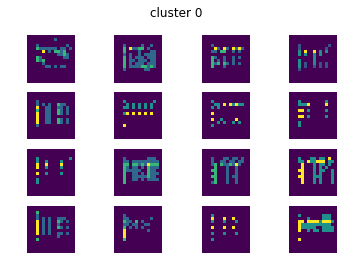

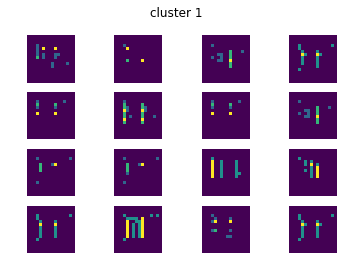

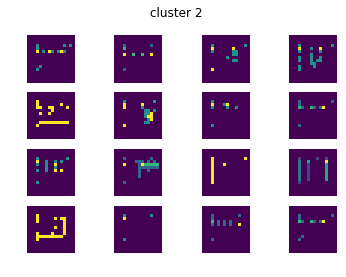

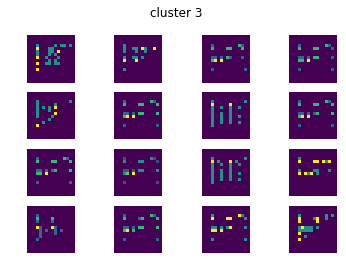

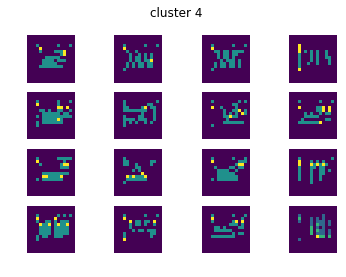

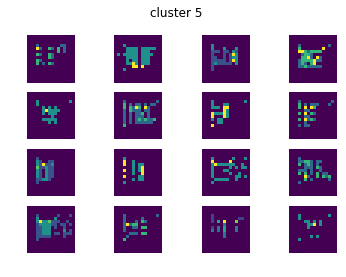

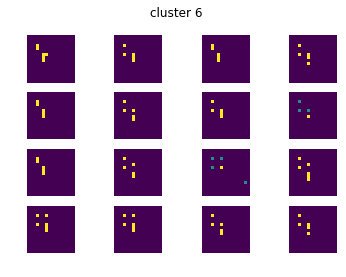

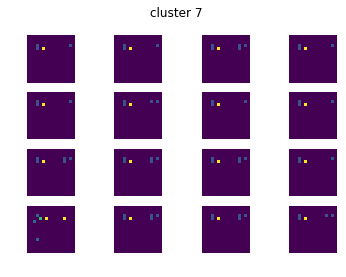

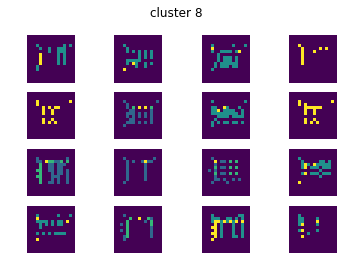

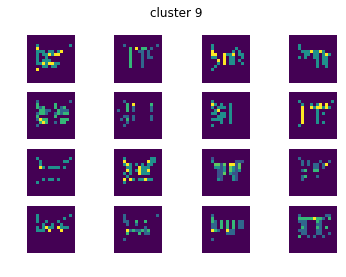

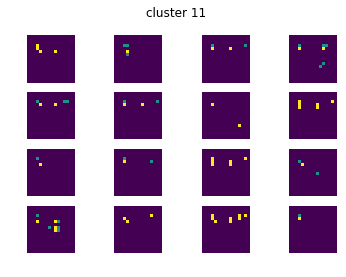

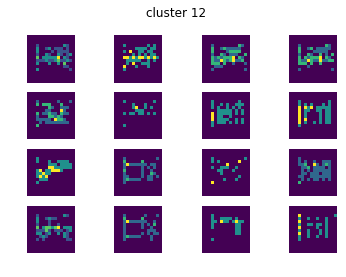

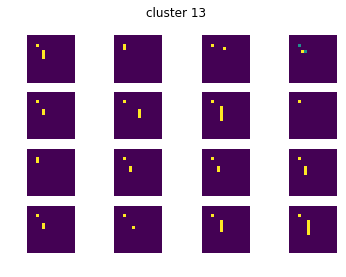

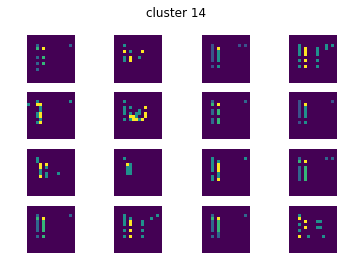

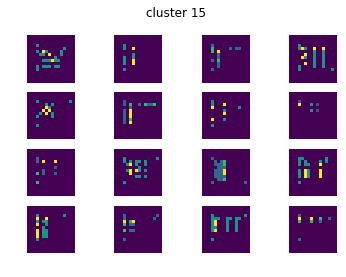

In [19]:
def tile_images(images, n):
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n, i * n + j + 1)
            plt.imshow(images[i * n + j].sum(-1))
            plt.axis('off')
            
n = 4
for c in set(cluster_ids):
    images = data['images'][cluster_ids == c]
    if images.shape[0] >= n**2:
        tile_images(images, n)
        plt.suptitle('cluster {}'.format(c))
        plt.show()